<a href="https://colab.research.google.com/github/alcarvalhox/Projeto-Eddy-Current/blob/master/C%C3%B3pia_de_EC_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import datetime
import math
import os
import sys
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
from numpy import *
import numpy as np
import scipy.io
from scipy import signal
from scipy.signal import medfilt
import seaborn as sns
import pywt
import csv
from PIL import Image
import argparse
import cv2 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model
import pylab as pl
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import Image, display


#################################################
from google.colab import drive
drive.mount("/content/drive/")

#################################################
try:
  path = '/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal'
  os.chdir(path)
except:
  print("Erro ao carregar diretorio no drive. Usado para drive compartilhado")

#################################################
print("Sistema preparado para rodar!")
print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Sistema preparado para rodar!
25-08-2020 18:56:59


# **Bloco de Classes**

In [102]:


#######################################
#### Leitura e Abertura de Arquivo ####
#######################################

class carrega_arquivo:
  def __init__(self):
    pass 

  def le_arquivo (self ,Path,File):
    #### Lê Arquivo .txt 
    with open(Path +'/'+ File, 'r') as f:
      # Usando a expressão regular para o separador indicando que eles são os espaços em branco
      df = pd.read_table(f, sep='\s+')
      df=df.replace(np.nan,0)
            

        # lista os cabeçalhos    
      cabecalho=df.columns

        # atribui a coluna do gráfico no indíce da coluna
      c = cabecalho[2]
        # define o comprimento da coluna
      a = len(df[cabecalho[2]])
        
        # cria vetor com quantidade de pontos
      x = np.arange(a)
        
        # define quantidade de linhas (pontos) e colunas
      linha = a
      coluna = 1
      
      return df[c]


##############################################################

#######################################
####        Filtra Sinais          ####
#######################################



class filtro:
  def __init__(self):
    pass

############### Spikes ################

  def tira_spikes(self,teste):

    resultado = []
    grad = (np.gradient(teste))
    valores = [int(val) for val in grad]

    for x in range (1,len(teste)):
        resultado.append(teste[x])

    for x in range (1,len(teste)):
        if abs(valores[x]) > (200):
            for x in range (x,(x+500)):
                resultado[x]=0 # Sinal Original Filtrado 
                
    resultado=signal.medfilt(resultado,kernel_size=11) 
    
    return resultado

############### Filtro  Media ################
  def filtro_media(self,sinalf,picos,janela2,mediainf,mediasup):

    (n,qsinais) = sinalf.shape  
    sinal=sinalf 
    contsinais =0
    janela4 = []
    picos4 = []

    for x in range(0,qsinais):
        if (np.mean(sinal[:,x])> mediainf) and (np.mean(sinal[:,x])< mediasup):
            janela4.append(janela2[x])
            picos4.append(picos[x])
            contsinais=contsinais+1
            
    #%%%% Cria matriz sinalfinal        
    sinalfinal = np.zeros(((amostras+1),(contsinais)))    

    #%%%% Coloca sinais filtrados por média na matriz sinalfinal
    qsinais2=0
    for x in range(0,(contsinais)):
        if (np.mean(sinal[:,x])> mediainf) and (np.mean(sinal[:,x])< mediasup):
            
            sinalfinal[:,qsinais2]=sinal[:,x]
            qsinais2=qsinais2+1

    return sinalfinal,janela4,picos4

  ############### Filtro  FFT ################
  def filtro_fft(self,sinalfinal,picos4,janela4):  

    (n,qsinais3) = sinalfinal.shape
    contasinais2 = 0
    janela5 = []
    picos5 = []

    for x in range(0,qsinais3):
        a=(max(np.fft.fft(sinalfinal[:,x])))
        #if a.imag != 0:
        if a.imag < 2000:    
            janela5.append(janela4[x])
            picos5.append(picos4[x])
            contasinais2=contasinais2+1
            
    # Cria matriz sinalfinal2
    sinalfinal2 = np.zeros(((amostras+1),(contasinais2)))

    # Coloca sinais filtrados por FFT na matriz sinalfinal2
    qsinais4 = 0

    for x in range(0,qsinais3):
        a=(max(np.fft.fft(sinalfinal[:,x])))
        #if a.imag != 0:
        if a.imag < 2000:    
            sinalfinal2[:,qsinais4] = sinalfinal[:,x]
            qsinais4=qsinais4+1    

    return sinalfinal2,janela5,picos5
  

################ Filtro Zerocross #################
  def filtro_zerocross(self,sinalfinal2,picos5,janela5,zerocross):

    (n,qsinais5) = sinalfinal2.shape
    contasinais3 = 0
    janela6 = []
    picos6 = []
    zero_x = 0

    for x in range(0,qsinais5):
        zero_x = 0
        for idx in range(1,(amostras-1)):
            if sinalfinal2[idx,x] < 0 and sinalfinal2[(idx+1),x] > 0:
                zero_x +=1
            if sinalfinal2[idx,x] > 0 and sinalfinal2[(idx+1),x] < 0:
                zero_x +=1
                
        if zero_x > zerocross:
            janela6.append(janela5[x])
            picos6.append(picos5[x])
            contasinais3=contasinais3+1
            
    # Cria matriz sinalfinal2
    sinalfinal3 = np.zeros(((amostras+1),(contasinais3)))

    # Coloca sinais filtrados por ZeroCross na matriz sinalfinal2
    qsinais6 = 0

    for x in range(0,qsinais5):
        zero_x = 0
        for idx in range(1,(amostras-1)):
            if sinalfinal2[idx,x] < 0 and sinalfinal2[(idx+1),x] > 0:
                zero_x +=1
            if sinalfinal2[idx,x] > 0 and sinalfinal2[(idx+1),x] < 0:
                zero_x +=1
        if zero_x > zerocross: 
            sinalfinal3[:,qsinais6] = sinalfinal2[:,x]
            qsinais6=qsinais6+1

    return sinalfinal3,janela6,picos6


################ Filtro Gradiente #################
  def filtro_gradiente(self,sinalfinal3,picos6,janela6,gradiente):

    (n,qsinais7) = sinalfinal3.shape
    contasinais4 = 0
    janela7 = []
    picos7 = []


    for x in range(0,qsinais7):
        
        if max(abs(np.gradient(sinalfinal3[:,x]))) < gradiente:
                
                janela7.append(janela6[x])
                picos7.append(picos6[x])
                contasinais4=contasinais4+1
                    

    # Cria matriz sinalfinal4
    sinalfinal4 = np.zeros(((amostras+1),(contasinais4)))
                    
    # Coloca sinais filtrados por Diferença de Constante na matriz sinalfinal4
    qsinais8 = 0

    for x in range(0,qsinais7):
        
            if max(abs(np.gradient(sinalfinal3[:,x]))) < gradiente:
                
                    sinalfinal4[:,qsinais8] = sinalfinal3[:,x]
                    qsinais8=qsinais8+1 
                    
    
    sinalfinal = sinalfinal4
    qsinais2 = qsinais8

    return sinalfinal4,janela7,picos7

######################################################################

#######################################
####     Padronização do Sinal     ####
#######################################

class padroniza_sinal:
  def __init__(self):
    pass

  def padroniza(self,resultado) :
    media = np.mean(resultado)
    sinalpadrao = (resultado-media)/np.std(resultado) 
    return sinalpadrao

#########################################################################

#######################################
####         Plotar Gráficos       ####
#######################################


class ClassePlote:

  def __init__(self):
    pass


#########################################################
  # Função realiza o plote de vetor x e y
  # Parametros:
  # - VetorX
  # - VetorY
  # - Xlabel
  # - Ylabel
  # - legend 
#########################################################
  def ploteLinha(self,VetorY, Xlabel, Ylabel, Legend):
    try:
      VetorX = list(range(1,(len(VetorY)+1)))
      plt.plot(VetorX, VetorY) #, linestyle='--', color="k")  
      #plt.scatter(VetorX, VetorY, color="r", marker="o", label=Legend)     
      plt.xlabel(Xlabel)
      plt.ylabel(Ylabel)
      plt.title(Legend)
      plt.grid(False)
      plt.show()
    except:
      print("Erro no metodo ploteLinha: na Linha {}".format(sys.exc_info()[-1].tb_lineno))
    
    
#########################################################
#Função realiza o plote histograma 1D
# Parametros: 
#########################################################
  def plotHistograma1D(self, Dado, Nbins, BoolDensity, Xlabel, Ylabel, Legend):
    try:
      bins =  OperadorPlot.hist(Dado, Nbins, density=BoolDensity, label=Legend)
      OperadorPlot.xlabel(Xlabel)
      OperadorPlot.ylabel(Ylabel)
      OperadorPlot.legend()       
      OperadorPlot.grid(True)
      OperadorPlot.show()
    except:
        print("Erro no metodo plotHistograma1D: na Linha {}".format(sys.exc_info()[-1].tb_lineno))
    
    
#########################################################
#Função realiza o plote de vetor x e y
# Parametros: 
#########################################################
  def getRandomVector(self, lenght, mu, sigma): 
    try:
        return (mu + sigma * np.random.randn(lenght))
    except:
        print("Erro no metodo getRandomVector: na Linha {}".format(sys.exc_info()[-1].tb_lineno))


#########################################################
#Função realiza o plote de sinais filtrados
# Parametros: 
#########################################################
  def plotar_sinais_filtrados(self,sinalfinal,comprimento):
    
    comp=comprimento
    qsinais2 = len(sinalfinal[0])
    linha = 0
    q = 0
    contador = 1
    linhas = range(0,(round(sinalfinal.shape[1]//2)))

    k= round((qsinais2/4)+1)
    if k == 1:
        k = 4
    k = round((qsinais2/4)+1)    


    #plt.rcParams['figure.figsize']=(10,10) 
    #plt.subplots_adjust(hspace = 1.4)
    fig, ax = plt.subplots((k), 4,figsize=(16.4,8.6))
    fig.tight_layout()

    for x in range(0,(sinalfinal.shape[1])):
        
                                
            plt.rcParams['xtick.labelsize'] = 5
            plt.rcParams['ytick.labelsize'] = 5 
        
            
            
            plt.subplot(ax.shape[0],ax.shape[1],(x+1))
            plt.subplots_adjust(hspace = 1.4)
            plt.plot(range(1,(amostras+2)),sinalfinal[:,(x)])
            a=str(x+1)
            b=str(janela7[x])
            c=str(int(picos7[x]))
            e=str(int(comp[x]))
            d=' Coord '
            y=' Sinal '
            z= ' Máximo '
            w= ' Comprimento '
            titulo = d + b + y + a + z + c + w + e 
            plt.title('Coord:  Sinal:  Máximo:  Comprimento:\n '+ b+'   '+a+'     '+c+'            '+e+'         ',fontsize=12)
            plt.show





#########################################################################

#######################################
####         Identifica Threshold   ###
#######################################

class Ident_thres:
  def __init__(self):
    pass

  def threshold_sinal(self,opcao,amostras,sinalvet,limite):
    #%%%% a é o número de pontos do sinal
    #%%%% Delay são os número de pontos que irão retroagir
    #%%%% Amostras é o tamaho da janela dos sinais identificados
    #%%%% Limite é valor do threshlod para filtrar ruídos iniciais

    a=len(sinalvet)

    if opcao == 1:
        a1=delay + 30000 # + 3000 - RODO 
    else:
        a1=delay + 10000
        
    t=1  
    cont1=1
    janela=[]


    while (a1<(a-amostras)):
        if (abs(sinalvet[a1]) >= limite):

            #%%%% define a próxima janela a ser analisada
            janela.append(a1)
            a1=a1+amostras

        if (abs(sinalvet[a1]) < limite):

            #%%% desconsidera pontos abaixo do threshold e analisa o próximo ponto   
            a1=a1+1 

    return janela          


#########################################################################

#######################################
####         Destaca Sinais         ###
#######################################


class sinais:
  def __init__ (self):
    pass

  def  destaca_sinais(self,janela,amostras,sinalvet):

    k=len(janela) # quantidade de janelas                         
    sinalf=np.zeros(((amostras+1),k))
    picos=np.zeros(k)
    conta=0                    
    janela2=[]


    while (conta<=(k-1)):
    
        for i in janela:
            if i > delay: 
            
                
                #%%%% destaca o sinal do sinal principal e inclui no vetor sinalf         
                #sinalf[:,conta]=sinalvet[(i-delay):(i+amostras-delay+1)]
                pico=max(abs(sinalvet [(i-delay):(i+amostras-delay+1)]))

                for x in range ((i-delay),(i+amostras-delay+1)):
                  if abs(sinalvet[x]) == pico:
                    picos[conta]=x
                
                inicio = int(picos[conta]-(amostras/2))  
                fim = int(picos[conta]+(amostras/2)+1) 

                dif=fim-inicio 

                while dif != (amostras+1):
                  if dif < (amostras+1):
                    fim=fim+1
                    dif=fim-inicio 
                  if dif > (amostras+1):
                    fim=fim-1
                    dif=fim-inicio   


                sinalf[:,conta]= sinalvet[inicio:fim]  
                    
                #%%%% aumenta o contador para armazenar o próximo sinal no vetor
                conta = conta + 1
                janela2.append(i)
                #%%%% define a próxima janela a ser analisada
                #a1=a1+amostras
     
    return sinalf,janela2,picos

##############################################
###### Mede Comprimento dos Sinais ###########
##############################################

class mede_comprimento:
  def  __init_ (self):
    pass

  def comprimento_sinal(self,sinalfinal):
    
    qsinais2=len(sinalfinal[0])
    comp=np.zeros(qsinais2)
    if opcao == 1: # Rodo
      constante = 9
    if opcao == 2: # Manual
      constante = 30

    for indice in range(0,qsinais2):
      #print('SINAL ',indice)
      q=sum(abs(sinalfinal[:,indice]**2))
      #print('Energia total sinal ','(',indice,')',' = ',q)
      a1=0
      a2=0
      w=0
      w2=0
      flag1=0
      flag2=0
      for x in range(1,len(sinalfinal[:,indice])):
          w=abs(sinalfinal[x,indice])**2
          w=w+w2
          
          if  ((0.02*q))<w< ((0.11*q)) and (flag1==0):
              a1=x 
              flag1=1

          if (0.98*q)<w< ((q)*1) and (flag2==0): 
              a2=x
              flag2=1
          w2=w  
      comp[indice]= (a2-a1)/constante
           
    return sinalfinal,comp
      #a1 Início do sinal) 
      #a2 Fim do sinal
      # a2-a1 Comprimento do Sinal 
      # w Energia mínima do sinal  
      # x Coordenada da Energia Mínima
      #plt.show()
      #plt.plot(sinalfinal[:,indice])
      #plt.plot(abs(sinalfinal[:,indice])**2)
      #plt.show()
      #plt.plot(sinalfinal[a1:a2,indice])
      #plt.show()


##########################################################
######## Executa a Transformada Wavelet do Sinal #########
##########################################################

class transf_wavelet:
  def __init__(self):
    pass

  def wavelet_sinal(self,nome_da_wavelet,escalas,cmap,amostras,caminho_figuras,sinalfinal):

    #familia2=['cgau1','cgau2','cgau3','cgau4','cgau5','cgau6','cgau7','cgau8','cmor','fbsp','gaus1','gaus2','gaus3','gaus4','gaus5','gaus6','gaus7','gaus8','mexh','morl','shan']
    waveletname = nome_da_wavelet
    #waveletname = 'cmor1.5-1.0'
    #escalas = 50
    #cmap = 'coolwarm'
    time = np.arange(0,(amostras+1))
    scales = np.arange(1, escalas)
    #path ='C:/Projeto Eddy Current/Supervisionado/Sinais/teste/imagemmorl'
    path = caminho_figuras 
    #path = 'C:/Projeto Eddy Current/Sinais_Coletados/Banco de Dados/Medidas_SVTS/SD/figuras3/'
    dt = 1
    #for x in range(0,len(familia2)):
    #for x in range(15,16):                       
    for x in range(0,len(sinalfinal[1])):       
        [coefficients, frequencies] = pywt.cwt(sinalfinal[:,(x)], scales, familia2[8], dt)
        power = (abs(coefficients)) ** 2
        period = 1. / frequencies
        levels = [0.03125,0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,16,32]
        contourlevels = np.log2(levels)

        a=str(x+1+1010)
        b = familia2[8]
        #l = str(3)
        #b = waveletname
        caminho = path+'/'+'solda'+a+'.jpg'
        im2 = plt.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
        plt.axis('off')
        plt.gca().invert_yaxis()
        plt.savefig(caminho,bbox_inches='tight',transparent = "true") 
        plt.gca().invert_yaxis()  

##########################################################
#### Executa o Modelo CNN Treinado para Classificação ####
##########################################################

class modelo_cnn():
  def __init__(self):
    pass

  def classifica_sinais (self,classLabels,caminho_figuras,caminho_modelo):

    #classLabels = classlabels 

    ############################
    # Transforma Imagem em array
    ############################
    class ImageToArrayPreprocessor:
      def __init__(self, dataFormat=None):
        # store the image data format
        self.dataFormat = dataFormat

      def preprocess(self, image):
        # apply the Keras utility function that correctly rearranges
        # the dimensions of the image
        return img_to_array(image, data_format=self.dataFormat)

    ####################################################
    # Faz o preprocessamento de imagens largura x altura
    ####################################################
    class SimplePreprocessor:
      def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

      def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect
        # ratio
        return cv2.resize(image, (self.width, self.height),
          interpolation=self.inter)
      
    ###################################
    # Carrega os dados e cria os labels
    ###################################
    class SimpleDatasetLoader:
      def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an
        # empty list
        if self.preprocessors is None:
          self.preprocessors = []

      def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
          # load the image and extract the class label assuming
          # that our path has the following format:
          # /path/to/dataset/{class}/{image}.jpg
          image = cv2.imread(imagePath)
          label = imagePath.split(os.path.sep)[-2]

          # check to see if our preprocessors are not None
          if self.preprocessors is not None:
            # loop over the preprocessors and apply each to
            # the image
            for p in self.preprocessors:
              image = p.preprocess(image)

          # treat our processed image as a "feature vector"
          # by updating the data list followed by the labels
          data.append(image)
          labels.append(label)

          # show an update every `verbose` images
          if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1,
              len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))
      

    #################################
    # Faz a validação do modelo #####
    #################################


    # construct the argument parse and parse the arguments
    #ap = argparse.ArgumentParser()
    #ap.add_argument("-d", "--dataset", required=True,
    #	help="path to input dataset")
    #ap.add_argument("-m", "--model", required=True,
    #	help="path to pre-trained model")
    #args = vars(ap.parse_args())

    # initialize the class labels
    #classLabels = ["junta_isolada","junta_seca", "solda"]
    #classLabels = classLabels 
    classLabels = ["cracking","junta","solda", "squat"]
    #classLabels = ["chef", "doctor", "engineer","farmer","firefighter","judge","mechanic","pilot","police","waiter"]
    #imagePaths = list(paths.list_images("/content/drive/My Drive/idenprof/idenprof/validacao"))

    # grab the list of images in the dataset then randomly sample
    # indexes into the image paths list
    #path_imagens = "/content/drive/My Drive/idenprof/idenprof/validacao"
    print("[INFO] sampling images...")
    #imagePaths = np.array(list(paths.list_images("/content/drive/My Drive/idenprof/idenprof/validacao")))
    imagePaths = np.array(list(paths.list_images(caminho_figuras)))
    idxs = linspace(0,(len(imagePaths)-1),(len(imagePaths)-1),dtype=int)
    print('ImagePaths: ',imagePaths)
    print('idxs: ',idxs)
    #idxs = np.random.randint(0, len(imagePaths), size=(15,))
    imagePaths = imagePaths[idxs]


    # initialize the image preprocessors
    sp = SimplePreprocessor(32, 32)
    iap = ImageToArrayPreprocessor()

    # load the dataset from disk then scale the raw pixel intensities
    # to the range [0, 1]
    sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
    (data, labels) = sdl.load(imagePaths)
    data = data.astype("float") / 255.0

    # load the pre-trained network
    #path_modelo = "/content/drive/My Drive/idenprof/idenprof/models/weights.hdf5"
    path_modelo = caminho_modelo
    print("[INFO] loading pre-trained network...")
    model = load_model(path_modelo)

    # make predictions on the images
    print("[INFO] predicting...")
    preds = model.predict(data, batch_size=32).argmax(axis=1)
    print('Classes :',preds)
    
    print('Labels',labels)

    # loop over the sample images
    for (i, imagePath) in enumerate(imagePaths):

      display(Image(imagePath))
      print(classLabels[preds[i]])
      
    #from PIL import Image

    #plt.figure(figsize=(10,10)) # specifying the overall grid size

    #for i in range(25):
    #for (i, imagePath) in enumerate(imagePaths):  
        #plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        #with open(filenames[i+1],'rb') as f:
          #image=Image.open(f)
          #plt.imshow(image)
          #plt.title(classLabels[preds[i]])
          #plt.close(image) 
    #plt.show()
    #image.close()


print("Classe carregada!")
print(datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

Classe carregada!
25-08-2020 20:34:31


# **Algoritmo Principal**

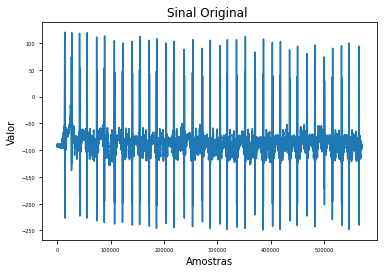

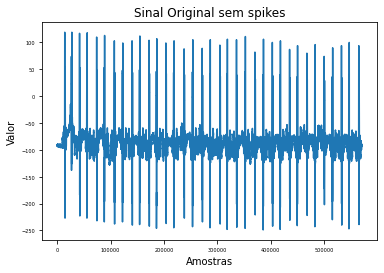

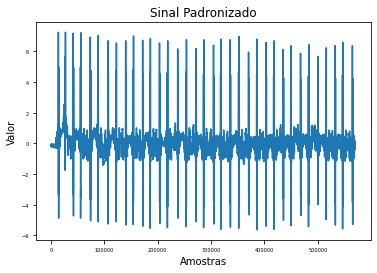

/usr/local/lib/python3.6/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:528: RuntimeWarning: divide by zero encountered in log2


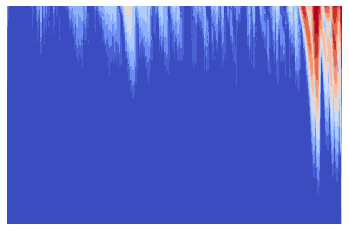

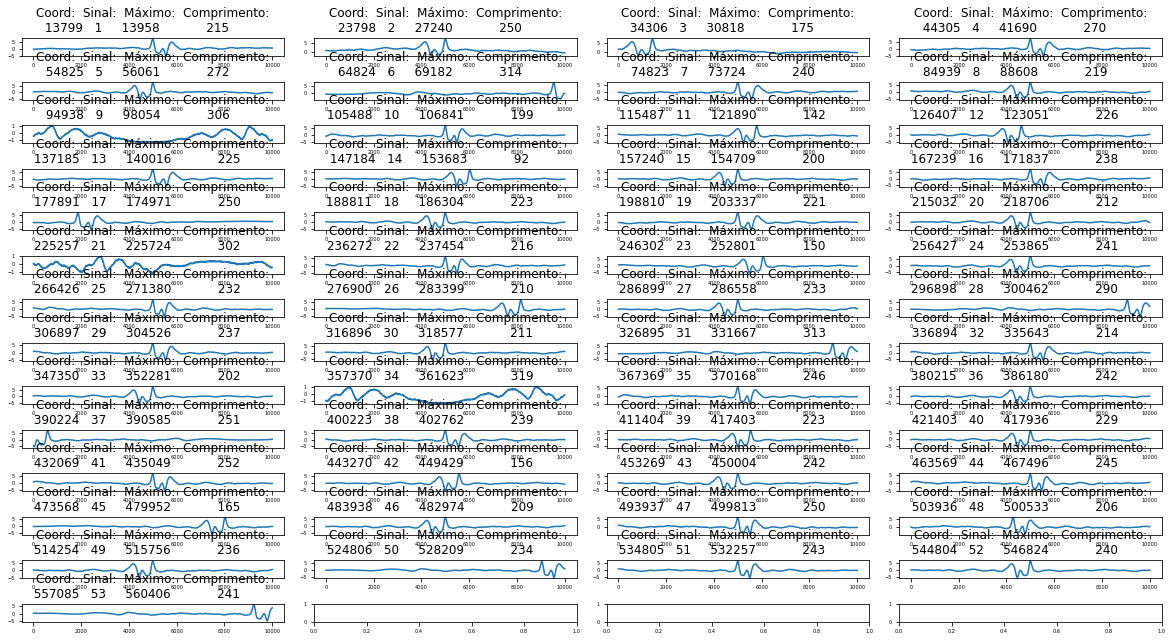

In [103]:
##########################  Início   ##########################################

########################## Definição do caminho do arquivo ####################
Path = "/content/drive/My Drive/Projeto Eddy Current/Sinais_Coletados/Banco de Dados/Medidas_SVTS_3/SD"
#Path = "/content/drive/My Drive/Projeto Eddy Current/Sinais_Coletados/Banco de Dados/Medidas_SVTS/JI"
#Path = "/content/drive/My Drive/Projeto Eddy Current/Sinais_Coletados/Banco de Dados/6-Coleta de dados com o RD58 Ramal Paraibuna (vma20kmh) 04-09-2019"
File = "sd4_0.txt"
#File = "jti9_0.txt"
#File = "Dados_SVTS_10.txt"

##############################################################################

#########################
# Definição de Variáveis#
#########################
wavelet = 0 # Se = 1 realiza a transformada wavelet
opcao=2  #1=sinal rodo  2=sinal manual
mediasup = 4.15 #0.55
mediainf = -6.15 #-0.35
zerocross = 2
tipo_de_grafico = 'flag'
escalas = 512
familia=['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau8', 'shan', 'fbsp', 'cmor']
familia2=['cgau1','cgau2','cgau3','cgau4','cgau5','cgau6','cgau7','cgau8','cmor','fbsp','gaus1','gaus2','gaus3','gaus4','gaus5','gaus6','gaus7','gaus8','mexh','morl','shan']
nome_da_wavelet = familia2[8]
escalas = 50
cmap = 'coolwarm'
classLabels = ["cracking","junta","Solda", "squat"]
caminho_figuras = '/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/Amostras/Solda'
caminho_modelo = '/content/drive/My Drive/Projeto Eddy Current/ProjetoFinal/modelo/weights50k5_4classes.hdf5'
#gradiente =  29 # 1.45 #3 sd  #9 manual #1.45 rodo
#path ='C:/Projeto Eddy Current/Supervisionado/Sinais/teste/imagem'

######################
# Opções de aquisição#
######################

if opcao == 1: # RODO 

    limite = 1 #4 #threshold superior
    limite2 = -200 #threshold inferior
    delay=800 #% RODO
    amostras=1499 # RODO
    const=20 # RODO
    gradiente = 1
    

if opcao == 2:# MANUAL 
   
    limite = 0.4#2 #1.8 #4 #0.7 (Junta) #threshold superior #0.7
    limite2 = -200 #threshold inferior
    delay=3500 #500 #250(Junta)Rodo # manual 40
    amostras=9999#7999 #2499 #799(Junta) #Rodo # manual 399
    const=20 #Rodo
    gradiente = 1

#######################################################################


####################  Leitura do Arquivo ##############################
### Cria Operador Arquivo
OperadorArquivos = carrega_arquivo()
### Recebe o arquivo lido
sinal=OperadorArquivos.le_arquivo(Path,File)

#x1=list(range(1,(len(sinal)+1)))


#####################  Filtra Spikes ###################################
### Cria Operador Filtro
OperadorFiltro=filtro()
### Recebe o arquivo sem spikes
resultado=OperadorFiltro.tira_spikes(sinal)

##################### Padroniza Sinal ###################################
### Cria Operador Padroniza Sinal
OperadorPadroniza = padroniza_sinal()
### Recebe o arquivo do sinal padronizado
sinalpadrao=OperadorPadroniza.padroniza(resultado) 


###################### Plota Sinal Principal ############################
### Cria Operador Plota Sinal
OperadorPlota = ClassePlote()
### Plota gráfico
OperadorPlota.ploteLinha(sinal,'Amostras','Valor','Sinal Original ')
OperadorPlota.ploteLinha(resultado,'Amostras','Valor','Sinal Original sem spikes')
OperadorPlota.ploteLinha(sinalpadrao,'Amostras','Valor','Sinal Padronizado')


####################### Destaca Sinais ###################################
### Cria Operador Threshold
OperadorThreshold = Ident_thres()
janela=OperadorThreshold.threshold_sinal(opcao,amostras,sinalpadrao,limite)

### Cria Operador Sinal
OperadorSinal=sinais()
### Destaca Sinais
(sinalf,janela2,picos)=OperadorSinal.destaca_sinais(janela,amostras,sinalpadrao)


###################### Filtra Sinal #########################################
### Filtro Média
(sinalfinal,janela4,picos4)=OperadorFiltro.filtro_media(sinalf,picos,janela2,mediainf,mediasup)
### Filtro FFT
(sinalfinal2,janela5,picos5)=OperadorFiltro.filtro_fft(sinalfinal,picos4,janela4)
### Filtro ZeroCross
(sinalfinal3,picos6,janela6)=OperadorFiltro.filtro_zerocross(sinalfinal2,picos5,janela5,zerocross)
### Filtro Gradiente
(sinalfinal4,picos7,janela7)=OperadorFiltro.filtro_gradiente(sinalfinal3,picos6,janela6,gradiente)


###################### Mede Sinal ############################################
### Cria Operador mede Sinal
Operador_mede_sinal=mede_comprimento()
### Mede Sinal
(sinalmedido,comprimento)=Operador_mede_sinal.comprimento_sinal(sinalfinal4)





##################### Executa a transformada Wavelet ########################
### Cria Operador Wavelet
Operador_wavelet=transf_wavelet()
################# Faz a Transformada Wavelet do Sinal e Grava 
Operador_wavelet.wavelet_sinal(nome_da_wavelet,escalas,cmap,amostras,caminho_figuras,sinalfinal4)


###################### Plota Sinal ###########################################
### Plota Sinais Filtrados
OperadorPlota.plotar_sinais_filtrados(sinalfinal4,comprimento)


################## Faz a classificação das categorias  ################
### Cria Operador Modelo CNN
#Operador_cnn=modelo_cnn()
### Faz a Classificação dos Sinais 
#Operador_cnn.classifica_sinais (classLabels,caminho_figuras,caminho_modelo)


################### Plota os sinais classificados no Google Earth ############







In [ ]:
print(len(sinalfinal[1]))
print(len(sinalfinal2[1]))
print(len(sinalfinal3[1]))
print(len(sinalfinal4[1]))




21
19
19
19


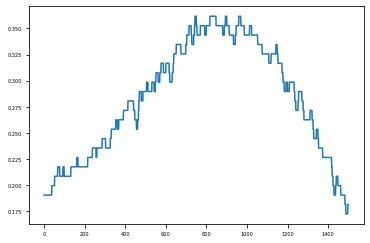

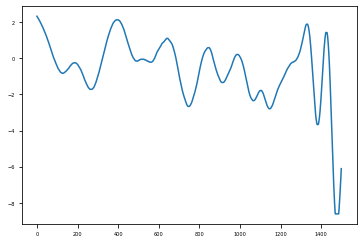

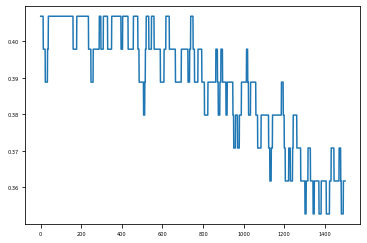

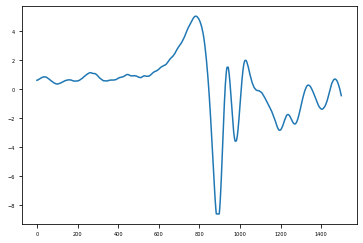

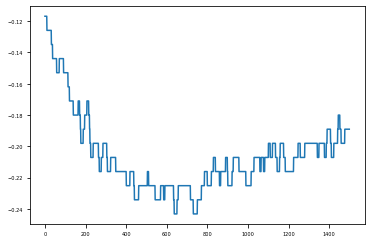

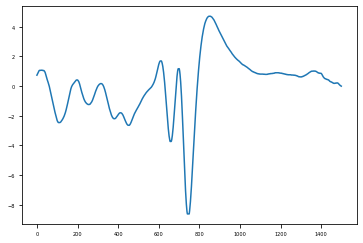

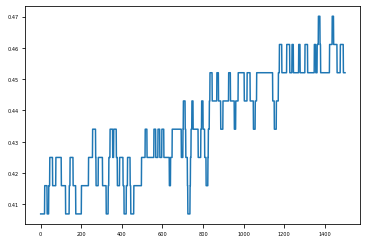

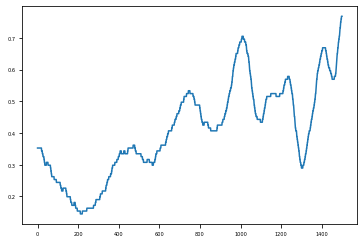

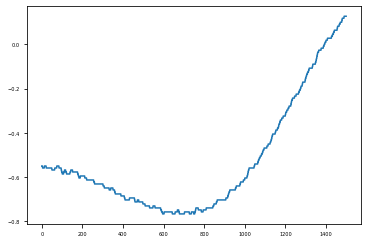

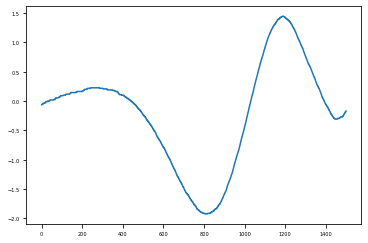

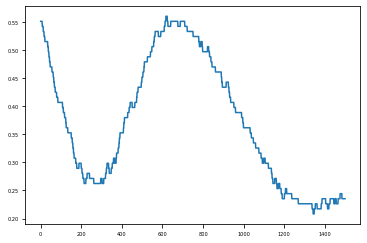

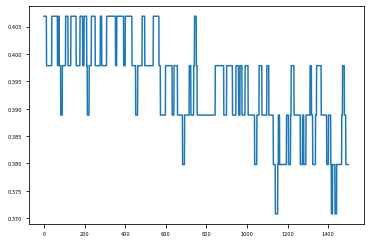

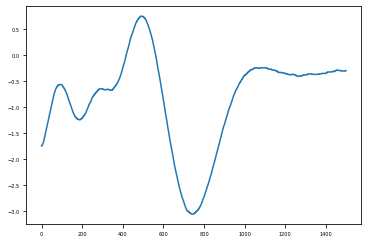

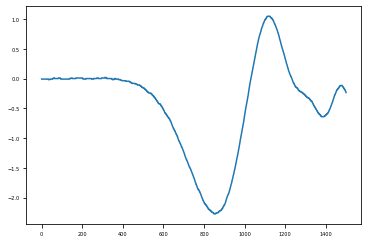

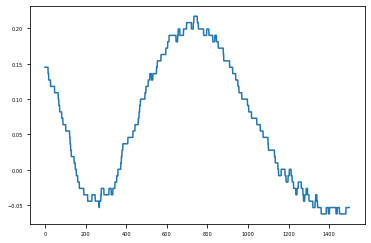

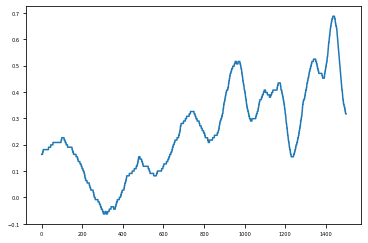

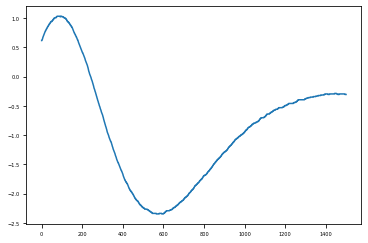

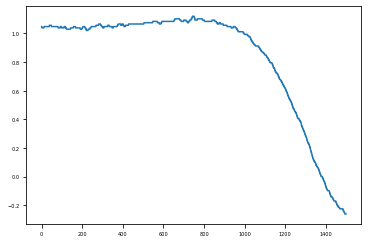

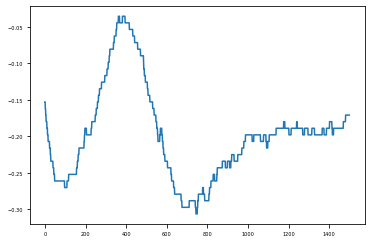

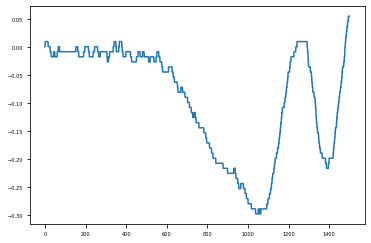

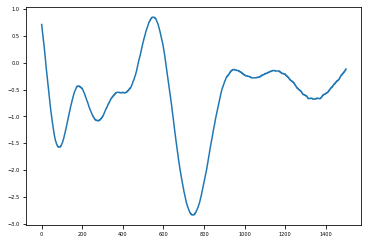

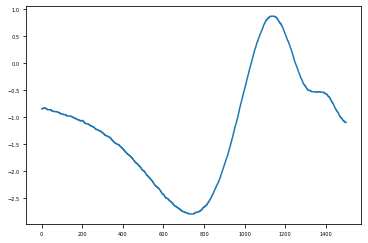

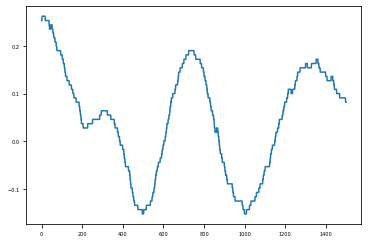

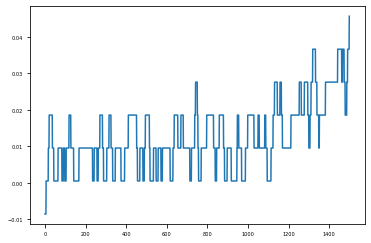

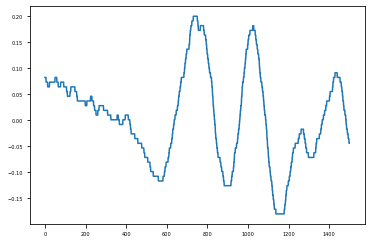

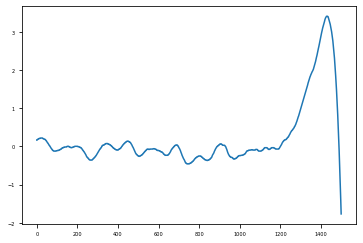

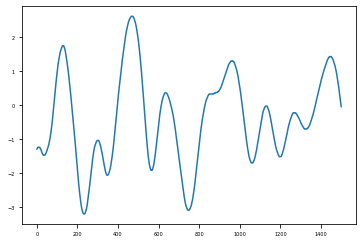

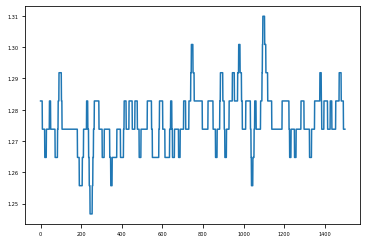

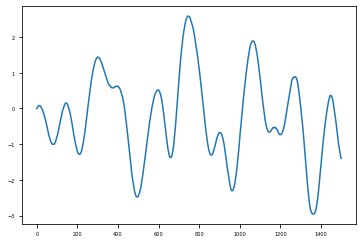

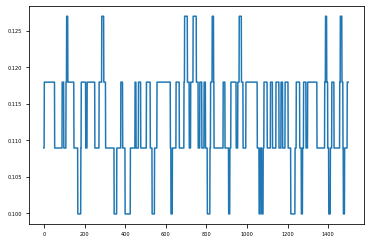

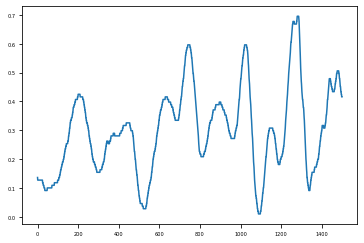

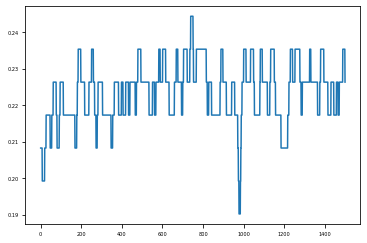

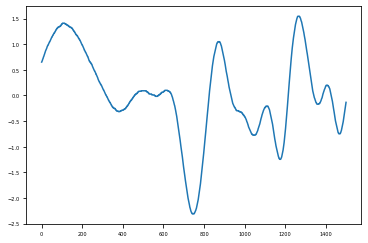

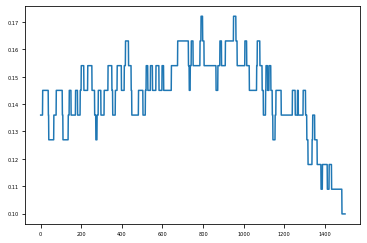

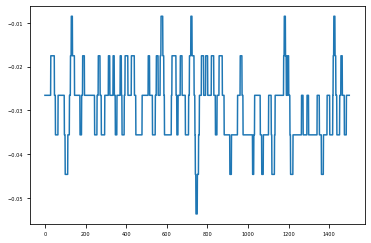

In [ ]:
for x in range(0,35):
  plt.plot(sinalfinal2[:,x])
  plt.show()